# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

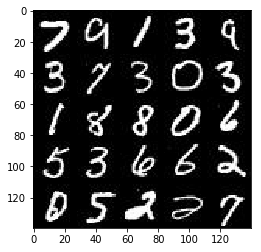

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

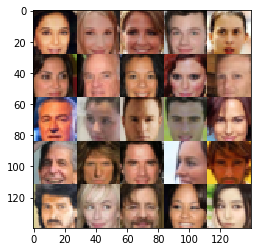

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, shape=(None, image_height, image_width, image_channels))
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim))
    learning_rate = tf.placeholder(tf.float32, shape=())

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


In [6]:
def lrelu(x, alpha):
    return tf.maximum(x * alpha, x)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [7]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    kinit = tf.random_normal_initializer(stddev=0.02)
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input is 28x28x3
        x = tf.layers.conv2d(images, 64, 5, strides=2, kernel_initializer=kinit, padding='same')
        x = lrelu(x, alpha)
        # 14x14x64
        
        x = tf.layers.conv2d(x, 128, 5, strides=2, kernel_initializer=kinit, padding='same')
        x = lrelu(x, alpha)
        x = tf.layers.batch_normalization(x, training=True)
        # 7x7x128
        
        x = tf.layers.conv2d(x, 256, 5, strides=2, kernel_initializer=kinit, padding='same')
        x = lrelu(x, alpha)
        x = tf.layers.batch_normalization(x, training=True)
        # 4x4x256
        
        x = tf.reshape(x, (-1, 4*4*256))
        logits = tf.layers.dense(x, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    kinit = tf.random_normal_initializer(stddev=0.02)
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        x = tf.layers.dense(z, 7*7*256)
        x = tf.reshape(x, (-1, 7, 7, 256))
        x = lrelu(x, alpha)
        x = tf.layers.batch_normalization(x, training=is_train)
        # 7x7x256
        
        x = tf.layers.conv2d_transpose(x, 128, 5, strides=2, kernel_initializer=kinit, padding='same')
        x = lrelu(x, alpha)
        x = tf.layers.batch_normalization(x, training=is_train)
        # 14x14x128
        
        x = tf.layers.conv2d_transpose(x, 64, 5, strides=2, kernel_initializer=kinit, padding='same')
        x = lrelu(x, alpha)
        x = tf.layers.batch_normalization(x, training=is_train)
        # 28x28x64
        
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 3, strides=1, kernel_initializer=kinit, padding='same')
        # 28x28x3
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    d_real_out, d_real_logits = discriminator(input_real, alpha=alpha)
    d_fake_out, d_fake_logits = discriminator(g_model, reuse=True, alpha=alpha)
    
    smooth = 0.1
    real_labels = tf.ones_like(d_real_out) * (1 - smooth)
    fake_labels = tf.zeros_like(d_fake_out)
    g_labels    = tf.ones_like(d_fake_out)

    d_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logits, labels=real_labels))
    d_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=fake_labels))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=g_labels))

    d_loss = d_real_loss + d_fake_loss
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [15]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    d_updates = [opt for opt in update_ops if opt.name.startswith('discriminator')]
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]

    with tf.control_dependencies(d_updates):
        d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

    with tf.control_dependencies(g_updates):
        g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
            
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, is_train=False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode,
          print_every=10, show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3], alpha=0.2)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.8801... Generator Loss: 1.0540
Epoch 1/2... Discriminator Loss: 0.5127... Generator Loss: 2.3333
Epoch 1/2... Discriminator Loss: 0.4545... Generator Loss: 2.8758
Epoch 1/2... Discriminator Loss: 0.4152... Generator Loss: 3.2468
Epoch 1/2... Discriminator Loss: 0.6928... Generator Loss: 2.5168
Epoch 1/2... Discriminator Loss: 0.3711... Generator Loss: 4.1552
Epoch 1/2... Discriminator Loss: 0.3676... Generator Loss: 3.7416
Epoch 1/2... Discriminator Loss: 0.3581... Generator Loss: 4.3737
Epoch 1/2... Discriminator Loss: 0.4236... Generator Loss: 5.2514
Epoch 1/2... Discriminator Loss: 0.3543... Generator Loss: 4.3852


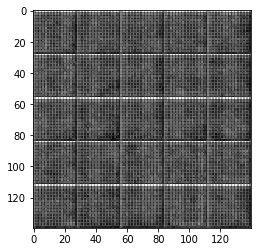

Epoch 1/2... Discriminator Loss: 0.3547... Generator Loss: 4.2637
Epoch 1/2... Discriminator Loss: 0.3568... Generator Loss: 4.1813
Epoch 1/2... Discriminator Loss: 0.3551... Generator Loss: 4.2720
Epoch 1/2... Discriminator Loss: 0.3836... Generator Loss: 4.8362
Epoch 1/2... Discriminator Loss: 0.3483... Generator Loss: 4.3271
Epoch 1/2... Discriminator Loss: 0.3597... Generator Loss: 4.3348
Epoch 1/2... Discriminator Loss: 0.3487... Generator Loss: 4.6943
Epoch 1/2... Discriminator Loss: 0.3502... Generator Loss: 4.3812
Epoch 1/2... Discriminator Loss: 0.4909... Generator Loss: 3.2533
Epoch 1/2... Discriminator Loss: 0.3703... Generator Loss: 4.8248


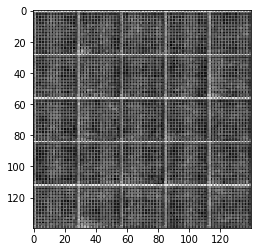

Epoch 1/2... Discriminator Loss: 0.4703... Generator Loss: 2.6707
Epoch 1/2... Discriminator Loss: 0.5069... Generator Loss: 2.5190
Epoch 1/2... Discriminator Loss: 0.4781... Generator Loss: 2.3098
Epoch 1/2... Discriminator Loss: 0.7111... Generator Loss: 1.3520
Epoch 1/2... Discriminator Loss: 0.4294... Generator Loss: 2.8118
Epoch 1/2... Discriminator Loss: 1.5103... Generator Loss: 6.1726
Epoch 1/2... Discriminator Loss: 0.4541... Generator Loss: 2.8281
Epoch 1/2... Discriminator Loss: 0.6304... Generator Loss: 3.7438
Epoch 1/2... Discriminator Loss: 0.8074... Generator Loss: 1.1612
Epoch 1/2... Discriminator Loss: 1.1773... Generator Loss: 0.6787


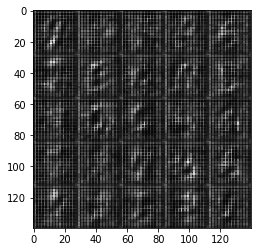

Epoch 1/2... Discriminator Loss: 1.5172... Generator Loss: 0.4859
Epoch 1/2... Discriminator Loss: 0.5473... Generator Loss: 2.0208
Epoch 1/2... Discriminator Loss: 0.6587... Generator Loss: 1.8916
Epoch 1/2... Discriminator Loss: 0.5527... Generator Loss: 2.1356
Epoch 1/2... Discriminator Loss: 0.7349... Generator Loss: 2.2900
Epoch 1/2... Discriminator Loss: 1.7555... Generator Loss: 4.9178
Epoch 1/2... Discriminator Loss: 0.6707... Generator Loss: 1.4438
Epoch 1/2... Discriminator Loss: 0.7565... Generator Loss: 2.3183
Epoch 1/2... Discriminator Loss: 0.5560... Generator Loss: 2.1883
Epoch 1/2... Discriminator Loss: 0.9045... Generator Loss: 0.9900


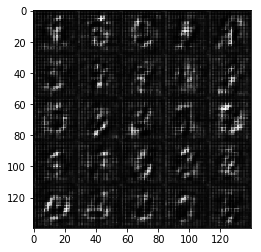

Epoch 1/2... Discriminator Loss: 0.7409... Generator Loss: 1.3076
Epoch 1/2... Discriminator Loss: 0.9885... Generator Loss: 3.0558
Epoch 1/2... Discriminator Loss: 0.7238... Generator Loss: 1.5938
Epoch 1/2... Discriminator Loss: 0.6773... Generator Loss: 1.5893
Epoch 1/2... Discriminator Loss: 0.6510... Generator Loss: 2.1304
Epoch 1/2... Discriminator Loss: 0.9019... Generator Loss: 2.3046
Epoch 1/2... Discriminator Loss: 0.7299... Generator Loss: 1.8103
Epoch 1/2... Discriminator Loss: 0.6947... Generator Loss: 1.6940
Epoch 1/2... Discriminator Loss: 0.8943... Generator Loss: 2.8900
Epoch 1/2... Discriminator Loss: 0.8089... Generator Loss: 1.1958


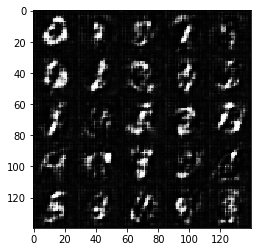

Epoch 1/2... Discriminator Loss: 0.6155... Generator Loss: 1.7623
Epoch 1/2... Discriminator Loss: 0.6007... Generator Loss: 2.1203
Epoch 1/2... Discriminator Loss: 0.5920... Generator Loss: 1.9340
Epoch 1/2... Discriminator Loss: 1.2801... Generator Loss: 0.6065
Epoch 1/2... Discriminator Loss: 0.7372... Generator Loss: 1.5010
Epoch 1/2... Discriminator Loss: 0.7226... Generator Loss: 1.3237
Epoch 1/2... Discriminator Loss: 0.6887... Generator Loss: 2.1813
Epoch 1/2... Discriminator Loss: 0.7267... Generator Loss: 1.3321
Epoch 1/2... Discriminator Loss: 0.9523... Generator Loss: 0.9652
Epoch 1/2... Discriminator Loss: 0.6819... Generator Loss: 1.5227


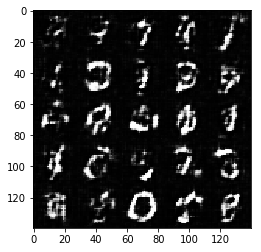

Epoch 1/2... Discriminator Loss: 0.8495... Generator Loss: 2.8928
Epoch 1/2... Discriminator Loss: 0.7666... Generator Loss: 1.2370
Epoch 1/2... Discriminator Loss: 0.6741... Generator Loss: 1.8742
Epoch 1/2... Discriminator Loss: 0.7540... Generator Loss: 2.2669
Epoch 1/2... Discriminator Loss: 0.7250... Generator Loss: 1.3609
Epoch 1/2... Discriminator Loss: 0.8420... Generator Loss: 2.3743
Epoch 1/2... Discriminator Loss: 0.7449... Generator Loss: 1.3835
Epoch 1/2... Discriminator Loss: 0.6961... Generator Loss: 1.8099
Epoch 1/2... Discriminator Loss: 0.7735... Generator Loss: 1.6094
Epoch 1/2... Discriminator Loss: 1.0687... Generator Loss: 2.3507


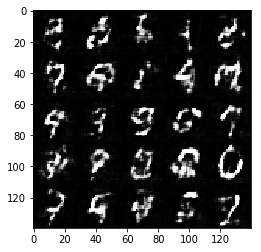

Epoch 1/2... Discriminator Loss: 0.8931... Generator Loss: 1.0387
Epoch 1/2... Discriminator Loss: 0.7545... Generator Loss: 1.9127
Epoch 1/2... Discriminator Loss: 0.7365... Generator Loss: 1.6595
Epoch 1/2... Discriminator Loss: 0.9047... Generator Loss: 0.9569
Epoch 1/2... Discriminator Loss: 0.8147... Generator Loss: 1.1824
Epoch 1/2... Discriminator Loss: 0.7936... Generator Loss: 1.7300
Epoch 1/2... Discriminator Loss: 0.8851... Generator Loss: 1.4535
Epoch 1/2... Discriminator Loss: 0.8688... Generator Loss: 1.1389
Epoch 1/2... Discriminator Loss: 0.8278... Generator Loss: 1.2339
Epoch 1/2... Discriminator Loss: 1.0505... Generator Loss: 2.5565


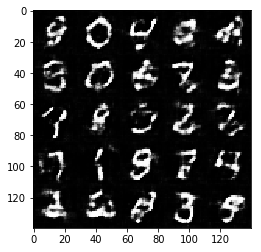

Epoch 1/2... Discriminator Loss: 1.2594... Generator Loss: 3.2767
Epoch 1/2... Discriminator Loss: 0.7711... Generator Loss: 1.5930
Epoch 1/2... Discriminator Loss: 0.7737... Generator Loss: 2.2825
Epoch 1/2... Discriminator Loss: 0.7970... Generator Loss: 1.7650
Epoch 1/2... Discriminator Loss: 0.9256... Generator Loss: 0.9603
Epoch 1/2... Discriminator Loss: 0.8236... Generator Loss: 1.2796
Epoch 1/2... Discriminator Loss: 0.8868... Generator Loss: 1.0886
Epoch 1/2... Discriminator Loss: 1.1632... Generator Loss: 2.5306
Epoch 1/2... Discriminator Loss: 0.7851... Generator Loss: 1.2544
Epoch 1/2... Discriminator Loss: 1.2192... Generator Loss: 0.6529


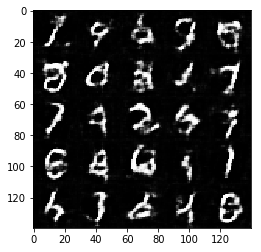

Epoch 1/2... Discriminator Loss: 0.8746... Generator Loss: 1.7620
Epoch 1/2... Discriminator Loss: 0.8923... Generator Loss: 0.9947
Epoch 1/2... Discriminator Loss: 0.7361... Generator Loss: 1.3895
Epoch 2/2... Discriminator Loss: 0.7791... Generator Loss: 1.4762
Epoch 2/2... Discriminator Loss: 1.0232... Generator Loss: 2.2136
Epoch 2/2... Discriminator Loss: 0.7309... Generator Loss: 1.6436
Epoch 2/2... Discriminator Loss: 0.7390... Generator Loss: 1.7624
Epoch 2/2... Discriminator Loss: 0.9205... Generator Loss: 0.9448
Epoch 2/2... Discriminator Loss: 0.9716... Generator Loss: 0.9384
Epoch 2/2... Discriminator Loss: 0.9337... Generator Loss: 0.9823


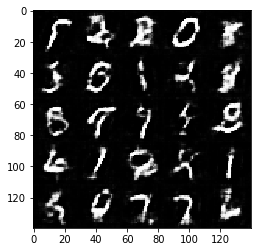

Epoch 2/2... Discriminator Loss: 0.8049... Generator Loss: 1.4693
Epoch 2/2... Discriminator Loss: 0.9150... Generator Loss: 1.0840
Epoch 2/2... Discriminator Loss: 0.8926... Generator Loss: 1.0157
Epoch 2/2... Discriminator Loss: 1.2592... Generator Loss: 0.5873
Epoch 2/2... Discriminator Loss: 0.9503... Generator Loss: 1.1181
Epoch 2/2... Discriminator Loss: 0.9542... Generator Loss: 1.0078
Epoch 2/2... Discriminator Loss: 0.8130... Generator Loss: 1.3809
Epoch 2/2... Discriminator Loss: 0.7956... Generator Loss: 1.4553
Epoch 2/2... Discriminator Loss: 0.8747... Generator Loss: 1.1229
Epoch 2/2... Discriminator Loss: 1.0039... Generator Loss: 0.8814


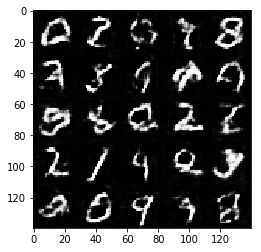

Epoch 2/2... Discriminator Loss: 0.8366... Generator Loss: 1.4372
Epoch 2/2... Discriminator Loss: 0.8395... Generator Loss: 1.2871
Epoch 2/2... Discriminator Loss: 0.8929... Generator Loss: 1.2209
Epoch 2/2... Discriminator Loss: 0.7538... Generator Loss: 1.5650
Epoch 2/2... Discriminator Loss: 0.9953... Generator Loss: 0.9483
Epoch 2/2... Discriminator Loss: 0.7611... Generator Loss: 1.5777
Epoch 2/2... Discriminator Loss: 0.9363... Generator Loss: 1.0892
Epoch 2/2... Discriminator Loss: 0.7848... Generator Loss: 1.4006
Epoch 2/2... Discriminator Loss: 1.1934... Generator Loss: 0.6869
Epoch 2/2... Discriminator Loss: 0.7758... Generator Loss: 1.7360


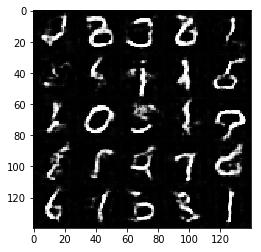

Epoch 2/2... Discriminator Loss: 0.8827... Generator Loss: 1.0773
Epoch 2/2... Discriminator Loss: 0.9166... Generator Loss: 1.0021
Epoch 2/2... Discriminator Loss: 0.9235... Generator Loss: 1.4153
Epoch 2/2... Discriminator Loss: 0.8644... Generator Loss: 1.8626
Epoch 2/2... Discriminator Loss: 0.8546... Generator Loss: 1.0893
Epoch 2/2... Discriminator Loss: 0.8592... Generator Loss: 1.4625
Epoch 2/2... Discriminator Loss: 0.8481... Generator Loss: 1.3537
Epoch 2/2... Discriminator Loss: 0.7923... Generator Loss: 1.5817
Epoch 2/2... Discriminator Loss: 1.0058... Generator Loss: 0.8793
Epoch 2/2... Discriminator Loss: 1.1700... Generator Loss: 0.7300


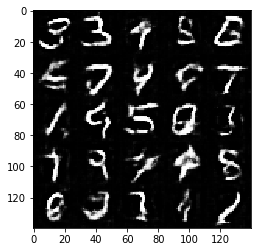

Epoch 2/2... Discriminator Loss: 0.8222... Generator Loss: 1.3919
Epoch 2/2... Discriminator Loss: 0.7397... Generator Loss: 1.3805
Epoch 2/2... Discriminator Loss: 0.8836... Generator Loss: 1.0954
Epoch 2/2... Discriminator Loss: 0.8083... Generator Loss: 2.2776
Epoch 2/2... Discriminator Loss: 0.8682... Generator Loss: 2.3058
Epoch 2/2... Discriminator Loss: 0.9815... Generator Loss: 0.8988
Epoch 2/2... Discriminator Loss: 0.8195... Generator Loss: 1.2942
Epoch 2/2... Discriminator Loss: 0.7542... Generator Loss: 1.5951
Epoch 2/2... Discriminator Loss: 0.7238... Generator Loss: 1.7653
Epoch 2/2... Discriminator Loss: 1.1085... Generator Loss: 1.8063


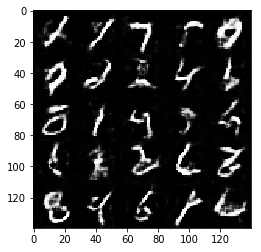

Epoch 2/2... Discriminator Loss: 0.8271... Generator Loss: 1.8613
Epoch 2/2... Discriminator Loss: 0.8941... Generator Loss: 1.8814
Epoch 2/2... Discriminator Loss: 0.8855... Generator Loss: 1.1219
Epoch 2/2... Discriminator Loss: 0.8536... Generator Loss: 1.2228
Epoch 2/2... Discriminator Loss: 0.7684... Generator Loss: 1.2439
Epoch 2/2... Discriminator Loss: 0.7814... Generator Loss: 1.8995
Epoch 2/2... Discriminator Loss: 1.1952... Generator Loss: 0.6595
Epoch 2/2... Discriminator Loss: 0.8902... Generator Loss: 1.7655
Epoch 2/2... Discriminator Loss: 0.9656... Generator Loss: 1.1813
Epoch 2/2... Discriminator Loss: 0.9080... Generator Loss: 1.7597


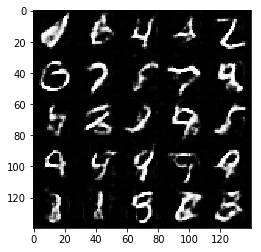

Epoch 2/2... Discriminator Loss: 1.0347... Generator Loss: 0.8705
Epoch 2/2... Discriminator Loss: 0.8338... Generator Loss: 1.1411
Epoch 2/2... Discriminator Loss: 1.0228... Generator Loss: 0.8330
Epoch 2/2... Discriminator Loss: 0.7761... Generator Loss: 1.5569
Epoch 2/2... Discriminator Loss: 0.8432... Generator Loss: 1.0434
Epoch 2/2... Discriminator Loss: 0.7660... Generator Loss: 1.3073
Epoch 2/2... Discriminator Loss: 0.9586... Generator Loss: 0.9609
Epoch 2/2... Discriminator Loss: 0.7631... Generator Loss: 1.5247
Epoch 2/2... Discriminator Loss: 0.8268... Generator Loss: 1.8850
Epoch 2/2... Discriminator Loss: 0.9108... Generator Loss: 1.3177


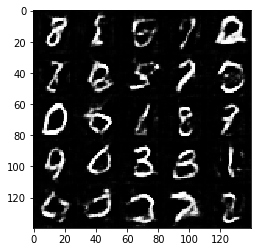

Epoch 2/2... Discriminator Loss: 0.8383... Generator Loss: 1.3088
Epoch 2/2... Discriminator Loss: 1.0428... Generator Loss: 0.8369
Epoch 2/2... Discriminator Loss: 0.7912... Generator Loss: 1.4139
Epoch 2/2... Discriminator Loss: 0.8146... Generator Loss: 1.6804
Epoch 2/2... Discriminator Loss: 0.9659... Generator Loss: 0.8982
Epoch 2/2... Discriminator Loss: 0.7409... Generator Loss: 1.9061
Epoch 2/2... Discriminator Loss: 0.9017... Generator Loss: 1.0769
Epoch 2/2... Discriminator Loss: 0.7614... Generator Loss: 1.4125
Epoch 2/2... Discriminator Loss: 0.8002... Generator Loss: 1.2648
Epoch 2/2... Discriminator Loss: 0.7630... Generator Loss: 1.8585


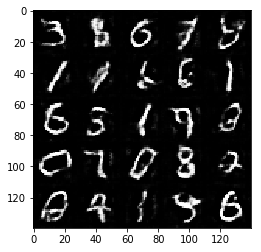

Epoch 2/2... Discriminator Loss: 0.8110... Generator Loss: 1.1648
Epoch 2/2... Discriminator Loss: 0.7957... Generator Loss: 1.5154
Epoch 2/2... Discriminator Loss: 0.8578... Generator Loss: 1.1131
Epoch 2/2... Discriminator Loss: 0.7578... Generator Loss: 1.2635
Epoch 2/2... Discriminator Loss: 1.0468... Generator Loss: 2.3467
Epoch 2/2... Discriminator Loss: 0.7112... Generator Loss: 1.5597
Epoch 2/2... Discriminator Loss: 0.7946... Generator Loss: 1.3466
Epoch 2/2... Discriminator Loss: 0.8645... Generator Loss: 1.9861
Epoch 2/2... Discriminator Loss: 0.8665... Generator Loss: 1.3186
Epoch 2/2... Discriminator Loss: 0.7898... Generator Loss: 1.2890


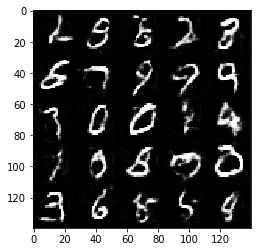

Epoch 2/2... Discriminator Loss: 0.8749... Generator Loss: 1.7382
Epoch 2/2... Discriminator Loss: 0.8786... Generator Loss: 1.0403
Epoch 2/2... Discriminator Loss: 0.6869... Generator Loss: 1.5866
Epoch 2/2... Discriminator Loss: 1.1582... Generator Loss: 0.7303
Epoch 2/2... Discriminator Loss: 0.8270... Generator Loss: 1.7323
Epoch 2/2... Discriminator Loss: 0.8839... Generator Loss: 1.0624
Epoch 2/2... Discriminator Loss: 0.8105... Generator Loss: 1.4999


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.3468... Generator Loss: 0.1881
Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.6399
Epoch 1/1... Discriminator Loss: 1.0303... Generator Loss: 0.9831
Epoch 1/1... Discriminator Loss: 0.9011... Generator Loss: 1.2373
Epoch 1/1... Discriminator Loss: 0.6996... Generator Loss: 3.3818
Epoch 1/1... Discriminator Loss: 0.5766... Generator Loss: 2.1284
Epoch 1/1... Discriminator Loss: 0.4638... Generator Loss: 4.9487
Epoch 1/1... Discriminator Loss: 0.7367... Generator Loss: 1.8333
Epoch 1/1... Discriminator Loss: 0.4414... Generator Loss: 2.9197
Epoch 1/1... Discriminator Loss: 0.9506... Generator Loss: 1.3271


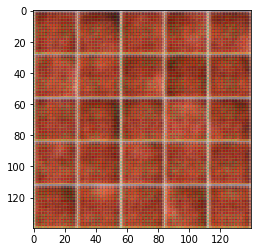

Epoch 1/1... Discriminator Loss: 0.9121... Generator Loss: 2.0152
Epoch 1/1... Discriminator Loss: 1.0755... Generator Loss: 1.0703
Epoch 1/1... Discriminator Loss: 2.4424... Generator Loss: 0.2043
Epoch 1/1... Discriminator Loss: 1.1903... Generator Loss: 0.9034
Epoch 1/1... Discriminator Loss: 1.9538... Generator Loss: 0.2942
Epoch 1/1... Discriminator Loss: 2.6076... Generator Loss: 0.1447
Epoch 1/1... Discriminator Loss: 1.5067... Generator Loss: 3.8648
Epoch 1/1... Discriminator Loss: 0.7772... Generator Loss: 2.6043
Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 0.7068
Epoch 1/1... Discriminator Loss: 0.9011... Generator Loss: 1.3582


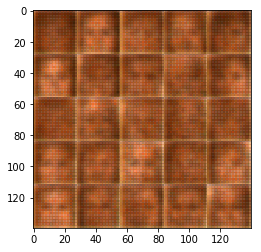

Epoch 1/1... Discriminator Loss: 1.0174... Generator Loss: 1.1881
Epoch 1/1... Discriminator Loss: 0.8117... Generator Loss: 1.6670
Epoch 1/1... Discriminator Loss: 1.0904... Generator Loss: 0.7702
Epoch 1/1... Discriminator Loss: 2.3690... Generator Loss: 0.1798
Epoch 1/1... Discriminator Loss: 1.1048... Generator Loss: 1.0143
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 2.1616
Epoch 1/1... Discriminator Loss: 1.2131... Generator Loss: 0.8489
Epoch 1/1... Discriminator Loss: 1.0236... Generator Loss: 1.2427
Epoch 1/1... Discriminator Loss: 1.1079... Generator Loss: 1.0266
Epoch 1/1... Discriminator Loss: 0.9908... Generator Loss: 2.1273


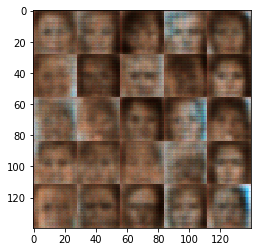

Epoch 1/1... Discriminator Loss: 0.9920... Generator Loss: 1.0422
Epoch 1/1... Discriminator Loss: 0.8445... Generator Loss: 1.6736
Epoch 1/1... Discriminator Loss: 1.1223... Generator Loss: 0.8961
Epoch 1/1... Discriminator Loss: 1.0045... Generator Loss: 1.4610
Epoch 1/1... Discriminator Loss: 0.9712... Generator Loss: 1.1696
Epoch 1/1... Discriminator Loss: 2.0673... Generator Loss: 0.2873
Epoch 1/1... Discriminator Loss: 1.1826... Generator Loss: 0.8394
Epoch 1/1... Discriminator Loss: 1.0649... Generator Loss: 1.1671
Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 1.6469
Epoch 1/1... Discriminator Loss: 1.1243... Generator Loss: 1.1031


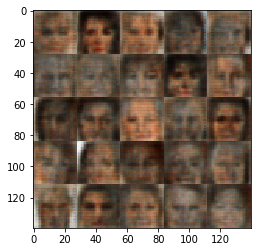

Epoch 1/1... Discriminator Loss: 1.7764... Generator Loss: 0.3748
Epoch 1/1... Discriminator Loss: 1.8492... Generator Loss: 0.3275
Epoch 1/1... Discriminator Loss: 1.7550... Generator Loss: 0.4089
Epoch 1/1... Discriminator Loss: 1.7019... Generator Loss: 0.4970
Epoch 1/1... Discriminator Loss: 1.2646... Generator Loss: 1.4712
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 1.7709... Generator Loss: 0.3433
Epoch 1/1... Discriminator Loss: 1.3013... Generator Loss: 0.8135
Epoch 1/1... Discriminator Loss: 1.5843... Generator Loss: 0.4488
Epoch 1/1... Discriminator Loss: 1.1625... Generator Loss: 1.0416


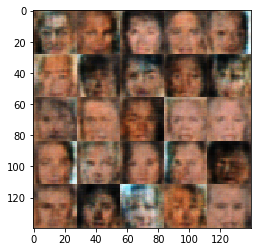

Epoch 1/1... Discriminator Loss: 1.2065... Generator Loss: 0.8875
Epoch 1/1... Discriminator Loss: 1.5989... Generator Loss: 0.4264
Epoch 1/1... Discriminator Loss: 1.3006... Generator Loss: 0.6889
Epoch 1/1... Discriminator Loss: 1.0998... Generator Loss: 0.9634
Epoch 1/1... Discriminator Loss: 1.4834... Generator Loss: 0.6549
Epoch 1/1... Discriminator Loss: 1.1628... Generator Loss: 1.1804
Epoch 1/1... Discriminator Loss: 1.3308... Generator Loss: 0.7339
Epoch 1/1... Discriminator Loss: 1.2899... Generator Loss: 0.7333
Epoch 1/1... Discriminator Loss: 1.4493... Generator Loss: 0.4820
Epoch 1/1... Discriminator Loss: 1.2128... Generator Loss: 0.8606


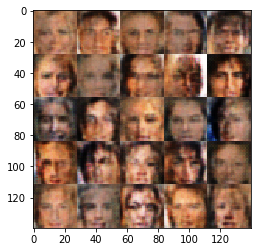

Epoch 1/1... Discriminator Loss: 1.0836... Generator Loss: 1.0537
Epoch 1/1... Discriminator Loss: 1.2515... Generator Loss: 1.0590
Epoch 1/1... Discriminator Loss: 1.1567... Generator Loss: 0.8925
Epoch 1/1... Discriminator Loss: 1.1765... Generator Loss: 0.8323
Epoch 1/1... Discriminator Loss: 1.1478... Generator Loss: 0.8293
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.7490
Epoch 1/1... Discriminator Loss: 1.2597... Generator Loss: 0.9886
Epoch 1/1... Discriminator Loss: 1.2226... Generator Loss: 0.9801
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.4903
Epoch 1/1... Discriminator Loss: 1.2980... Generator Loss: 0.8714


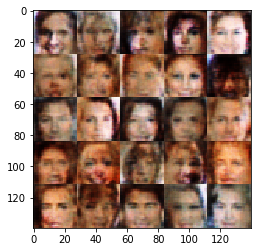

Epoch 1/1... Discriminator Loss: 1.3303... Generator Loss: 0.6442
Epoch 1/1... Discriminator Loss: 1.1746... Generator Loss: 1.2036
Epoch 1/1... Discriminator Loss: 1.1747... Generator Loss: 0.7916
Epoch 1/1... Discriminator Loss: 1.1811... Generator Loss: 0.8416
Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 1.1018
Epoch 1/1... Discriminator Loss: 1.1897... Generator Loss: 0.8142
Epoch 1/1... Discriminator Loss: 1.1255... Generator Loss: 0.8451
Epoch 1/1... Discriminator Loss: 1.2178... Generator Loss: 0.8632
Epoch 1/1... Discriminator Loss: 1.0730... Generator Loss: 0.9097
Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 0.6609


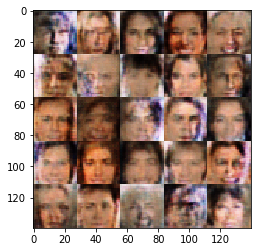

Epoch 1/1... Discriminator Loss: 1.3035... Generator Loss: 0.6674
Epoch 1/1... Discriminator Loss: 1.1473... Generator Loss: 0.8068
Epoch 1/1... Discriminator Loss: 0.9352... Generator Loss: 1.1524
Epoch 1/1... Discriminator Loss: 1.2698... Generator Loss: 0.6200
Epoch 1/1... Discriminator Loss: 1.1931... Generator Loss: 0.8036
Epoch 1/1... Discriminator Loss: 1.2697... Generator Loss: 1.1975
Epoch 1/1... Discriminator Loss: 1.2433... Generator Loss: 0.7679
Epoch 1/1... Discriminator Loss: 1.1971... Generator Loss: 0.7490
Epoch 1/1... Discriminator Loss: 1.1933... Generator Loss: 0.7052
Epoch 1/1... Discriminator Loss: 1.1081... Generator Loss: 0.9729


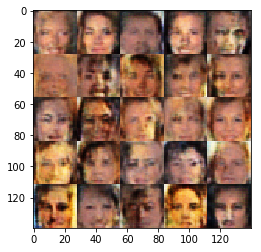

Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.6801
Epoch 1/1... Discriminator Loss: 1.2596... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 1.0755... Generator Loss: 0.9506
Epoch 1/1... Discriminator Loss: 1.1383... Generator Loss: 0.9556
Epoch 1/1... Discriminator Loss: 1.2210... Generator Loss: 1.0122
Epoch 1/1... Discriminator Loss: 1.2237... Generator Loss: 0.8592
Epoch 1/1... Discriminator Loss: 1.0592... Generator Loss: 0.9668
Epoch 1/1... Discriminator Loss: 1.1509... Generator Loss: 0.9607
Epoch 1/1... Discriminator Loss: 1.2870... Generator Loss: 0.8281
Epoch 1/1... Discriminator Loss: 1.0495... Generator Loss: 1.0331


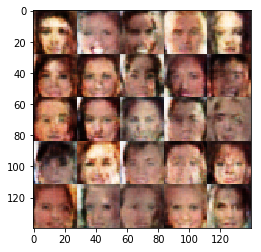

Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 0.5642
Epoch 1/1... Discriminator Loss: 1.1947... Generator Loss: 0.7463
Epoch 1/1... Discriminator Loss: 1.0661... Generator Loss: 0.8473
Epoch 1/1... Discriminator Loss: 1.2507... Generator Loss: 0.7307
Epoch 1/1... Discriminator Loss: 1.1769... Generator Loss: 0.7265
Epoch 1/1... Discriminator Loss: 0.9441... Generator Loss: 1.4128
Epoch 1/1... Discriminator Loss: 1.3281... Generator Loss: 1.1900
Epoch 1/1... Discriminator Loss: 1.2289... Generator Loss: 1.0785
Epoch 1/1... Discriminator Loss: 1.0997... Generator Loss: 1.2117
Epoch 1/1... Discriminator Loss: 1.2085... Generator Loss: 0.7182


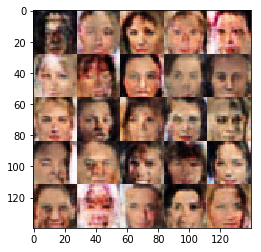

Epoch 1/1... Discriminator Loss: 1.0635... Generator Loss: 0.9005
Epoch 1/1... Discriminator Loss: 0.9710... Generator Loss: 1.0289
Epoch 1/1... Discriminator Loss: 1.1495... Generator Loss: 0.7381
Epoch 1/1... Discriminator Loss: 1.2835... Generator Loss: 0.7880
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.5476
Epoch 1/1... Discriminator Loss: 1.0473... Generator Loss: 1.0589
Epoch 1/1... Discriminator Loss: 1.1379... Generator Loss: 1.0803
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.5444
Epoch 1/1... Discriminator Loss: 1.2624... Generator Loss: 0.6251
Epoch 1/1... Discriminator Loss: 1.2166... Generator Loss: 1.0320


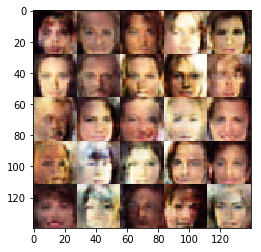

Epoch 1/1... Discriminator Loss: 1.3100... Generator Loss: 0.7792
Epoch 1/1... Discriminator Loss: 1.3176... Generator Loss: 0.6335
Epoch 1/1... Discriminator Loss: 1.2940... Generator Loss: 0.6253
Epoch 1/1... Discriminator Loss: 1.2946... Generator Loss: 0.6743
Epoch 1/1... Discriminator Loss: 1.1746... Generator Loss: 0.7585
Epoch 1/1... Discriminator Loss: 1.2621... Generator Loss: 0.7322
Epoch 1/1... Discriminator Loss: 1.1788... Generator Loss: 0.8260
Epoch 1/1... Discriminator Loss: 1.0928... Generator Loss: 0.8719
Epoch 1/1... Discriminator Loss: 1.0696... Generator Loss: 0.9765
Epoch 1/1... Discriminator Loss: 1.0819... Generator Loss: 1.0652


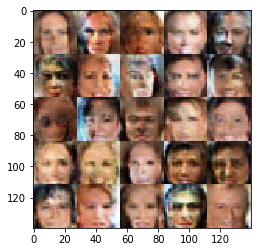

Epoch 1/1... Discriminator Loss: 1.2294... Generator Loss: 1.6495
Epoch 1/1... Discriminator Loss: 1.0494... Generator Loss: 0.8712
Epoch 1/1... Discriminator Loss: 1.1604... Generator Loss: 0.7816
Epoch 1/1... Discriminator Loss: 1.0584... Generator Loss: 1.0759
Epoch 1/1... Discriminator Loss: 1.0992... Generator Loss: 0.9648
Epoch 1/1... Discriminator Loss: 1.1990... Generator Loss: 0.8514
Epoch 1/1... Discriminator Loss: 1.0166... Generator Loss: 1.1282
Epoch 1/1... Discriminator Loss: 1.1896... Generator Loss: 0.7894
Epoch 1/1... Discriminator Loss: 1.2543... Generator Loss: 0.6237
Epoch 1/1... Discriminator Loss: 1.5445... Generator Loss: 0.5234


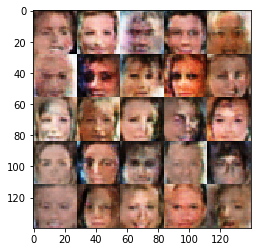

Epoch 1/1... Discriminator Loss: 1.0702... Generator Loss: 0.9666
Epoch 1/1... Discriminator Loss: 1.3613... Generator Loss: 0.6031
Epoch 1/1... Discriminator Loss: 1.4743... Generator Loss: 1.5043
Epoch 1/1... Discriminator Loss: 1.4613... Generator Loss: 0.4768
Epoch 1/1... Discriminator Loss: 1.3476... Generator Loss: 0.5673
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.5309
Epoch 1/1... Discriminator Loss: 1.0233... Generator Loss: 1.0958
Epoch 1/1... Discriminator Loss: 1.2210... Generator Loss: 0.9232
Epoch 1/1... Discriminator Loss: 1.1289... Generator Loss: 0.9741
Epoch 1/1... Discriminator Loss: 1.2407... Generator Loss: 0.5971


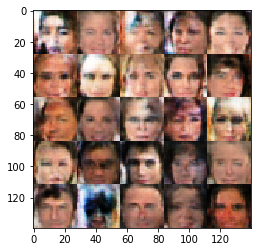

Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 0.6692
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.1169... Generator Loss: 0.7186
Epoch 1/1... Discriminator Loss: 1.2005... Generator Loss: 0.7061
Epoch 1/1... Discriminator Loss: 1.5961... Generator Loss: 0.4287
Epoch 1/1... Discriminator Loss: 1.0667... Generator Loss: 0.9123
Epoch 1/1... Discriminator Loss: 1.0677... Generator Loss: 0.8432
Epoch 1/1... Discriminator Loss: 1.3059... Generator Loss: 0.7293
Epoch 1/1... Discriminator Loss: 1.2557... Generator Loss: 0.7789
Epoch 1/1... Discriminator Loss: 1.1642... Generator Loss: 0.7653


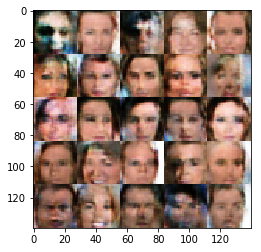

Epoch 1/1... Discriminator Loss: 1.2746... Generator Loss: 0.6438
Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.6764
Epoch 1/1... Discriminator Loss: 1.1843... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 1.0693... Generator Loss: 0.9376
Epoch 1/1... Discriminator Loss: 1.1185... Generator Loss: 0.8315
Epoch 1/1... Discriminator Loss: 1.0981... Generator Loss: 1.0427
Epoch 1/1... Discriminator Loss: 1.2905... Generator Loss: 0.5607
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.5488
Epoch 1/1... Discriminator Loss: 1.2147... Generator Loss: 0.8077
Epoch 1/1... Discriminator Loss: 1.4655... Generator Loss: 0.4887


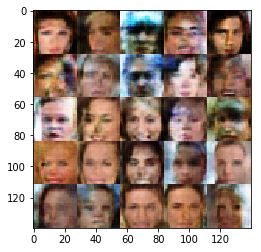

Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.6641
Epoch 1/1... Discriminator Loss: 1.3527... Generator Loss: 0.6567
Epoch 1/1... Discriminator Loss: 1.0812... Generator Loss: 1.1453
Epoch 1/1... Discriminator Loss: 1.3501... Generator Loss: 0.5716
Epoch 1/1... Discriminator Loss: 1.3497... Generator Loss: 0.5120
Epoch 1/1... Discriminator Loss: 1.0568... Generator Loss: 0.9479
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.5275
Epoch 1/1... Discriminator Loss: 1.2292... Generator Loss: 0.7259
Epoch 1/1... Discriminator Loss: 1.1120... Generator Loss: 1.2051
Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 0.6702


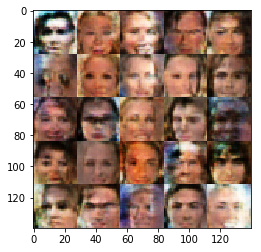

Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.6819
Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 0.5922
Epoch 1/1... Discriminator Loss: 1.5747... Generator Loss: 0.4842
Epoch 1/1... Discriminator Loss: 1.1168... Generator Loss: 0.7840
Epoch 1/1... Discriminator Loss: 1.5745... Generator Loss: 0.4796
Epoch 1/1... Discriminator Loss: 1.2375... Generator Loss: 0.7163
Epoch 1/1... Discriminator Loss: 1.6742... Generator Loss: 0.4404
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.6596
Epoch 1/1... Discriminator Loss: 1.2449... Generator Loss: 0.6270
Epoch 1/1... Discriminator Loss: 1.1043... Generator Loss: 0.9546


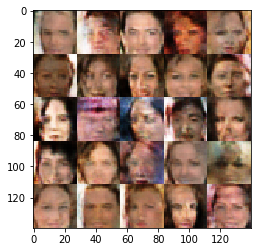

Epoch 1/1... Discriminator Loss: 1.0985... Generator Loss: 0.9414
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.5477
Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.5909
Epoch 1/1... Discriminator Loss: 1.0878... Generator Loss: 0.7740
Epoch 1/1... Discriminator Loss: 1.6863... Generator Loss: 0.4244
Epoch 1/1... Discriminator Loss: 1.2710... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 1.0891... Generator Loss: 0.8502
Epoch 1/1... Discriminator Loss: 1.5148... Generator Loss: 0.4869
Epoch 1/1... Discriminator Loss: 1.0986... Generator Loss: 0.9305


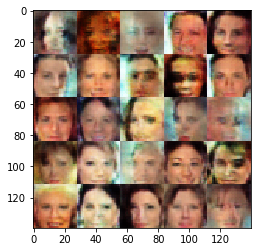

Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.4981
Epoch 1/1... Discriminator Loss: 1.1702... Generator Loss: 0.9569
Epoch 1/1... Discriminator Loss: 1.1712... Generator Loss: 0.9961
Epoch 1/1... Discriminator Loss: 1.2560... Generator Loss: 0.8195
Epoch 1/1... Discriminator Loss: 1.1548... Generator Loss: 0.9174
Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 0.7299
Epoch 1/1... Discriminator Loss: 1.0418... Generator Loss: 1.0641
Epoch 1/1... Discriminator Loss: 1.2121... Generator Loss: 1.3570
Epoch 1/1... Discriminator Loss: 1.1515... Generator Loss: 0.6814
Epoch 1/1... Discriminator Loss: 1.2266... Generator Loss: 1.4886


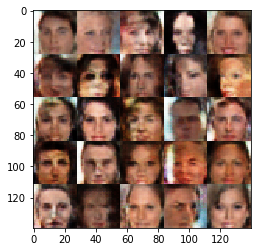

Epoch 1/1... Discriminator Loss: 0.9671... Generator Loss: 1.2079
Epoch 1/1... Discriminator Loss: 1.2720... Generator Loss: 0.7047
Epoch 1/1... Discriminator Loss: 1.2073... Generator Loss: 1.1184
Epoch 1/1... Discriminator Loss: 1.2771... Generator Loss: 0.6509
Epoch 1/1... Discriminator Loss: 0.8996... Generator Loss: 1.1615
Epoch 1/1... Discriminator Loss: 1.3132... Generator Loss: 0.7516
Epoch 1/1... Discriminator Loss: 1.2946... Generator Loss: 0.5624
Epoch 1/1... Discriminator Loss: 1.3157... Generator Loss: 0.6254
Epoch 1/1... Discriminator Loss: 1.2146... Generator Loss: 0.7014
Epoch 1/1... Discriminator Loss: 1.0669... Generator Loss: 1.0228


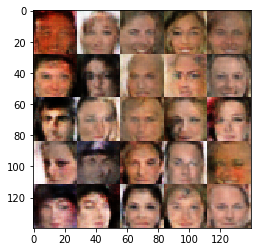

Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 1.2300... Generator Loss: 0.7147
Epoch 1/1... Discriminator Loss: 1.0572... Generator Loss: 1.2356
Epoch 1/1... Discriminator Loss: 0.9367... Generator Loss: 1.1530
Epoch 1/1... Discriminator Loss: 1.1163... Generator Loss: 0.8354
Epoch 1/1... Discriminator Loss: 1.2216... Generator Loss: 0.7098
Epoch 1/1... Discriminator Loss: 1.2053... Generator Loss: 0.7034
Epoch 1/1... Discriminator Loss: 1.1439... Generator Loss: 0.8785
Epoch 1/1... Discriminator Loss: 1.1623... Generator Loss: 0.8528
Epoch 1/1... Discriminator Loss: 1.5094... Generator Loss: 0.8121


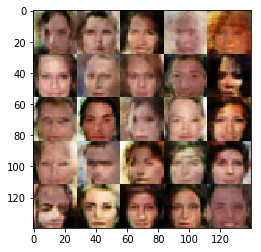

Epoch 1/1... Discriminator Loss: 1.0712... Generator Loss: 1.0705
Epoch 1/1... Discriminator Loss: 1.3497... Generator Loss: 0.5432
Epoch 1/1... Discriminator Loss: 1.0863... Generator Loss: 0.8383
Epoch 1/1... Discriminator Loss: 1.2006... Generator Loss: 0.8675
Epoch 1/1... Discriminator Loss: 1.2630... Generator Loss: 0.6849
Epoch 1/1... Discriminator Loss: 1.6153... Generator Loss: 0.6337
Epoch 1/1... Discriminator Loss: 1.0218... Generator Loss: 0.9474
Epoch 1/1... Discriminator Loss: 1.3036... Generator Loss: 0.6333
Epoch 1/1... Discriminator Loss: 0.9662... Generator Loss: 1.0739
Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.6074


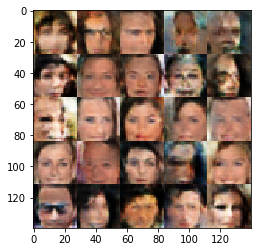

Epoch 1/1... Discriminator Loss: 1.0633... Generator Loss: 0.8824
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 1.1806... Generator Loss: 0.7221
Epoch 1/1... Discriminator Loss: 1.2459... Generator Loss: 0.7440
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 0.7442
Epoch 1/1... Discriminator Loss: 1.0389... Generator Loss: 1.0371
Epoch 1/1... Discriminator Loss: 1.1330... Generator Loss: 0.8080
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.6658
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 0.6597
Epoch 1/1... Discriminator Loss: 1.5671... Generator Loss: 0.4988


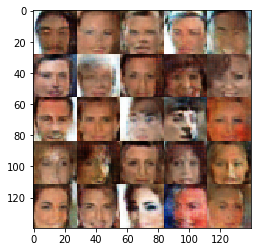

Epoch 1/1... Discriminator Loss: 1.2849... Generator Loss: 0.8760
Epoch 1/1... Discriminator Loss: 1.1147... Generator Loss: 0.9987
Epoch 1/1... Discriminator Loss: 1.0851... Generator Loss: 0.9846
Epoch 1/1... Discriminator Loss: 1.2283... Generator Loss: 0.7352
Epoch 1/1... Discriminator Loss: 1.3509... Generator Loss: 0.6652
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 0.8648
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.5303
Epoch 1/1... Discriminator Loss: 1.6209... Generator Loss: 0.4344
Epoch 1/1... Discriminator Loss: 1.2078... Generator Loss: 0.7741
Epoch 1/1... Discriminator Loss: 1.0961... Generator Loss: 0.8633


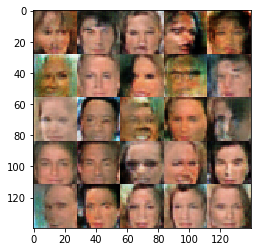

Epoch 1/1... Discriminator Loss: 1.2738... Generator Loss: 0.8127
Epoch 1/1... Discriminator Loss: 1.1634... Generator Loss: 0.8775
Epoch 1/1... Discriminator Loss: 1.1571... Generator Loss: 0.8402
Epoch 1/1... Discriminator Loss: 1.3351... Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 1.0994... Generator Loss: 0.8822
Epoch 1/1... Discriminator Loss: 1.1930... Generator Loss: 0.7361
Epoch 1/1... Discriminator Loss: 1.7014... Generator Loss: 0.3667
Epoch 1/1... Discriminator Loss: 1.1278... Generator Loss: 0.8020
Epoch 1/1... Discriminator Loss: 1.1230... Generator Loss: 0.8498
Epoch 1/1... Discriminator Loss: 1.3044... Generator Loss: 0.6027


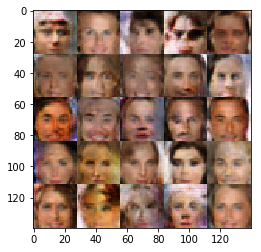

Epoch 1/1... Discriminator Loss: 1.2256... Generator Loss: 1.0241
Epoch 1/1... Discriminator Loss: 1.3273... Generator Loss: 0.8431
Epoch 1/1... Discriminator Loss: 1.0896... Generator Loss: 0.9413
Epoch 1/1... Discriminator Loss: 1.0423... Generator Loss: 1.0388
Epoch 1/1... Discriminator Loss: 1.0253... Generator Loss: 1.0364
Epoch 1/1... Discriminator Loss: 1.0992... Generator Loss: 0.9675
Epoch 1/1... Discriminator Loss: 1.1028... Generator Loss: 0.7884
Epoch 1/1... Discriminator Loss: 1.6094... Generator Loss: 0.4472
Epoch 1/1... Discriminator Loss: 1.2141... Generator Loss: 0.8708
Epoch 1/1... Discriminator Loss: 1.4426... Generator Loss: 0.5701


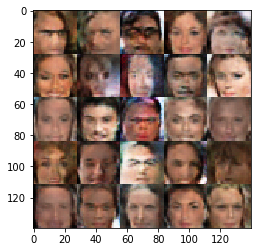

Epoch 1/1... Discriminator Loss: 1.1793... Generator Loss: 0.7507
Epoch 1/1... Discriminator Loss: 1.4589... Generator Loss: 0.5776
Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.6179
Epoch 1/1... Discriminator Loss: 1.1932... Generator Loss: 0.7313
Epoch 1/1... Discriminator Loss: 1.2299... Generator Loss: 0.6544
Epoch 1/1... Discriminator Loss: 1.2721... Generator Loss: 0.8103
Epoch 1/1... Discriminator Loss: 1.2131... Generator Loss: 0.7740
Epoch 1/1... Discriminator Loss: 1.2772... Generator Loss: 0.9101
Epoch 1/1... Discriminator Loss: 1.2850... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 1.2209... Generator Loss: 0.8531


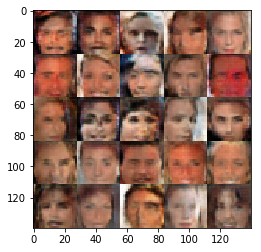

Epoch 1/1... Discriminator Loss: 1.1468... Generator Loss: 1.0775
Epoch 1/1... Discriminator Loss: 1.2754... Generator Loss: 0.7919
Epoch 1/1... Discriminator Loss: 1.1928... Generator Loss: 1.0108
Epoch 1/1... Discriminator Loss: 1.4579... Generator Loss: 1.1869
Epoch 1/1... Discriminator Loss: 1.5597... Generator Loss: 0.4486
Epoch 1/1... Discriminator Loss: 1.4133... Generator Loss: 0.5313
Epoch 1/1... Discriminator Loss: 1.1648... Generator Loss: 0.9451
Epoch 1/1... Discriminator Loss: 1.0780... Generator Loss: 1.1083
Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 0.6076
Epoch 1/1... Discriminator Loss: 1.8698... Generator Loss: 0.2875


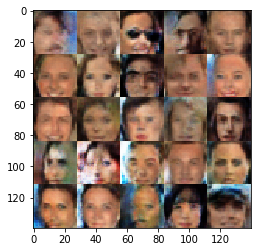

Epoch 1/1... Discriminator Loss: 1.2957... Generator Loss: 0.6135
Epoch 1/1... Discriminator Loss: 1.1399... Generator Loss: 0.8833
Epoch 1/1... Discriminator Loss: 1.7784... Generator Loss: 0.3174
Epoch 1/1... Discriminator Loss: 1.3391... Generator Loss: 0.8107
Epoch 1/1... Discriminator Loss: 1.0964... Generator Loss: 0.9517
Epoch 1/1... Discriminator Loss: 0.9558... Generator Loss: 1.1635
Epoch 1/1... Discriminator Loss: 1.2633... Generator Loss: 0.6706
Epoch 1/1... Discriminator Loss: 1.1710... Generator Loss: 0.8107
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.5796
Epoch 1/1... Discriminator Loss: 1.4822... Generator Loss: 0.5510


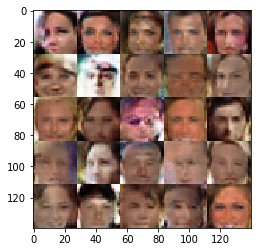

Epoch 1/1... Discriminator Loss: 1.5011... Generator Loss: 0.8368
Epoch 1/1... Discriminator Loss: 1.2873... Generator Loss: 0.9537
Epoch 1/1... Discriminator Loss: 1.3195... Generator Loss: 0.7278
Epoch 1/1... Discriminator Loss: 1.3714... Generator Loss: 0.5833
Epoch 1/1... Discriminator Loss: 1.2260... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 1.3344... Generator Loss: 0.6316
Epoch 1/1... Discriminator Loss: 1.2339... Generator Loss: 1.0146
Epoch 1/1... Discriminator Loss: 1.2103... Generator Loss: 0.8579
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.7822
Epoch 1/1... Discriminator Loss: 1.0825... Generator Loss: 1.0070


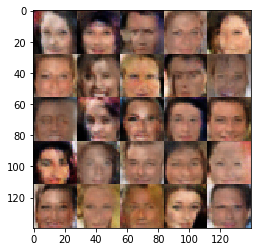

Epoch 1/1... Discriminator Loss: 1.3417... Generator Loss: 0.6688
Epoch 1/1... Discriminator Loss: 1.1844... Generator Loss: 0.8109
Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 0.7299
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.5984
Epoch 1/1... Discriminator Loss: 1.2744... Generator Loss: 0.8968
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.6124
Epoch 1/1... Discriminator Loss: 1.6140... Generator Loss: 0.4095
Epoch 1/1... Discriminator Loss: 1.0976... Generator Loss: 0.8982
Epoch 1/1... Discriminator Loss: 1.2157... Generator Loss: 0.9021
Epoch 1/1... Discriminator Loss: 1.1765... Generator Loss: 0.8124


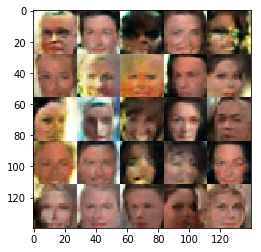

Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 0.6878
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.3443... Generator Loss: 0.6405
Epoch 1/1... Discriminator Loss: 1.2903... Generator Loss: 0.8792
Epoch 1/1... Discriminator Loss: 1.2102... Generator Loss: 1.0777
Epoch 1/1... Discriminator Loss: 1.0398... Generator Loss: 1.5327
Epoch 1/1... Discriminator Loss: 1.2839... Generator Loss: 0.7171
Epoch 1/1... Discriminator Loss: 1.3425... Generator Loss: 0.5768
Epoch 1/1... Discriminator Loss: 1.7628... Generator Loss: 0.3600
Epoch 1/1... Discriminator Loss: 1.3129... Generator Loss: 0.6808


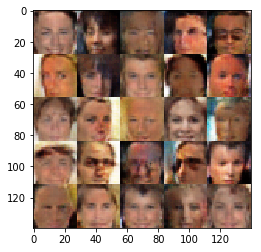

Epoch 1/1... Discriminator Loss: 1.2853... Generator Loss: 0.6476
Epoch 1/1... Discriminator Loss: 1.3267... Generator Loss: 0.7257
Epoch 1/1... Discriminator Loss: 1.1575... Generator Loss: 0.7327
Epoch 1/1... Discriminator Loss: 1.1084... Generator Loss: 0.7924
Epoch 1/1... Discriminator Loss: 1.1962... Generator Loss: 0.7697
Epoch 1/1... Discriminator Loss: 1.2370... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 1.5368... Generator Loss: 0.7409
Epoch 1/1... Discriminator Loss: 1.0861... Generator Loss: 0.8469
Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.6980
Epoch 1/1... Discriminator Loss: 1.1950... Generator Loss: 0.7689


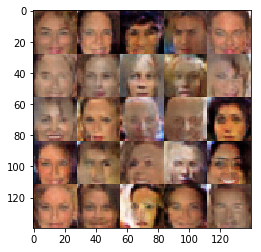

Epoch 1/1... Discriminator Loss: 1.5338... Generator Loss: 0.4702
Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.5610
Epoch 1/1... Discriminator Loss: 1.1865... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.4923
Epoch 1/1... Discriminator Loss: 1.2757... Generator Loss: 0.6664
Epoch 1/1... Discriminator Loss: 1.2286... Generator Loss: 0.7302
Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 0.6794
Epoch 1/1... Discriminator Loss: 1.2242... Generator Loss: 0.6536
Epoch 1/1... Discriminator Loss: 1.2863... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 1.1479... Generator Loss: 0.7500


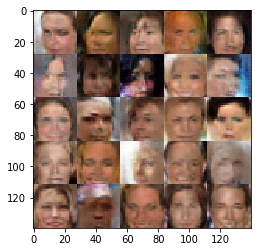

Epoch 1/1... Discriminator Loss: 1.2744... Generator Loss: 0.6673
Epoch 1/1... Discriminator Loss: 1.1507... Generator Loss: 0.8387
Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.4834
Epoch 1/1... Discriminator Loss: 1.2163... Generator Loss: 0.8605
Epoch 1/1... Discriminator Loss: 1.2673... Generator Loss: 0.6119
Epoch 1/1... Discriminator Loss: 1.1346... Generator Loss: 0.7320
Epoch 1/1... Discriminator Loss: 1.1224... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 0.9421... Generator Loss: 1.0841
Epoch 1/1... Discriminator Loss: 1.2389... Generator Loss: 0.6869
Epoch 1/1... Discriminator Loss: 1.1929... Generator Loss: 0.7230


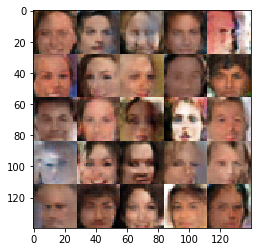

Epoch 1/1... Discriminator Loss: 1.2782... Generator Loss: 0.9681
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.7503
Epoch 1/1... Discriminator Loss: 1.0563... Generator Loss: 0.9720
Epoch 1/1... Discriminator Loss: 1.2997... Generator Loss: 0.5957
Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 0.6398
Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 0.6245
Epoch 1/1... Discriminator Loss: 1.2763... Generator Loss: 0.7531
Epoch 1/1... Discriminator Loss: 1.6115... Generator Loss: 0.3880
Epoch 1/1... Discriminator Loss: 1.0357... Generator Loss: 0.9151
Epoch 1/1... Discriminator Loss: 1.1733... Generator Loss: 0.8107


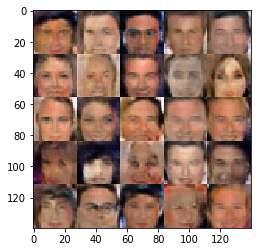

Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.6035
Epoch 1/1... Discriminator Loss: 1.2466... Generator Loss: 0.6275
Epoch 1/1... Discriminator Loss: 1.3271... Generator Loss: 0.7343
Epoch 1/1... Discriminator Loss: 1.6189... Generator Loss: 0.4293
Epoch 1/1... Discriminator Loss: 1.2467... Generator Loss: 0.6750
Epoch 1/1... Discriminator Loss: 1.2047... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 1.3411... Generator Loss: 0.7416
Epoch 1/1... Discriminator Loss: 1.5688... Generator Loss: 0.4609
Epoch 1/1... Discriminator Loss: 1.0401... Generator Loss: 1.0684
Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.4858


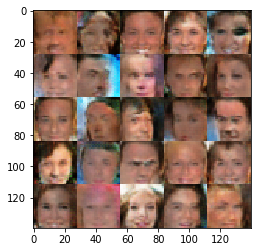

Epoch 1/1... Discriminator Loss: 1.1903... Generator Loss: 0.7768
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.5186
Epoch 1/1... Discriminator Loss: 1.3116... Generator Loss: 0.6742
Epoch 1/1... Discriminator Loss: 1.1673... Generator Loss: 0.9490
Epoch 1/1... Discriminator Loss: 1.1866... Generator Loss: 0.8883
Epoch 1/1... Discriminator Loss: 1.2005... Generator Loss: 0.8813
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.6953
Epoch 1/1... Discriminator Loss: 1.3554... Generator Loss: 0.6562
Epoch 1/1... Discriminator Loss: 1.1332... Generator Loss: 1.0131
Epoch 1/1... Discriminator Loss: 1.1137... Generator Loss: 0.8597


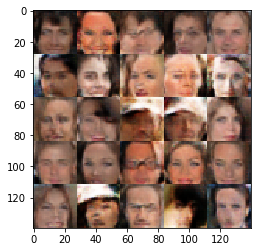

Epoch 1/1... Discriminator Loss: 0.9118... Generator Loss: 1.1681
Epoch 1/1... Discriminator Loss: 1.3496... Generator Loss: 0.5231
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.6038
Epoch 1/1... Discriminator Loss: 1.3562... Generator Loss: 0.5847
Epoch 1/1... Discriminator Loss: 1.1554... Generator Loss: 0.8442
Epoch 1/1... Discriminator Loss: 1.1531... Generator Loss: 0.8233
Epoch 1/1... Discriminator Loss: 1.2967... Generator Loss: 0.7411
Epoch 1/1... Discriminator Loss: 1.0761... Generator Loss: 1.2222
Epoch 1/1... Discriminator Loss: 1.0500... Generator Loss: 1.1780
Epoch 1/1... Discriminator Loss: 1.0046... Generator Loss: 1.0212


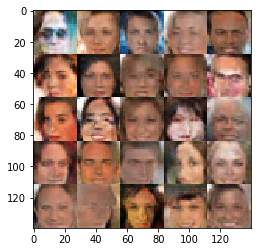

Epoch 1/1... Discriminator Loss: 1.4578... Generator Loss: 0.5222
Epoch 1/1... Discriminator Loss: 0.8992... Generator Loss: 1.0524
Epoch 1/1... Discriminator Loss: 1.6109... Generator Loss: 0.4642
Epoch 1/1... Discriminator Loss: 1.4881... Generator Loss: 0.5406
Epoch 1/1... Discriminator Loss: 1.1920... Generator Loss: 0.8255
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.5870
Epoch 1/1... Discriminator Loss: 1.0078... Generator Loss: 1.0408
Epoch 1/1... Discriminator Loss: 1.2359... Generator Loss: 0.6975
Epoch 1/1... Discriminator Loss: 1.2341... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 1.3069... Generator Loss: 0.6212


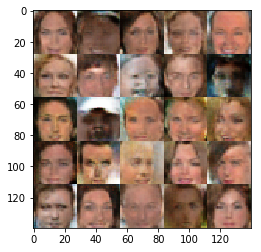

Epoch 1/1... Discriminator Loss: 1.3255... Generator Loss: 0.5521
Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 0.7069
Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 0.7841
Epoch 1/1... Discriminator Loss: 1.1461... Generator Loss: 0.7541
Epoch 1/1... Discriminator Loss: 1.0882... Generator Loss: 0.8923
Epoch 1/1... Discriminator Loss: 1.1598... Generator Loss: 0.8011
Epoch 1/1... Discriminator Loss: 1.2841... Generator Loss: 0.9279
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.5562
Epoch 1/1... Discriminator Loss: 1.0725... Generator Loss: 0.8384
Epoch 1/1... Discriminator Loss: 1.1261... Generator Loss: 1.0153


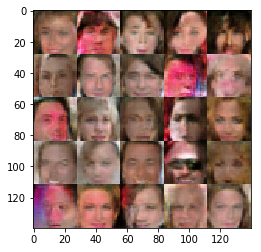

Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 0.6082
Epoch 1/1... Discriminator Loss: 1.5266... Generator Loss: 0.4470
Epoch 1/1... Discriminator Loss: 1.2813... Generator Loss: 0.7242
Epoch 1/1... Discriminator Loss: 1.1009... Generator Loss: 1.0206
Epoch 1/1... Discriminator Loss: 1.0748... Generator Loss: 0.9428
Epoch 1/1... Discriminator Loss: 1.2088... Generator Loss: 0.7387
Epoch 1/1... Discriminator Loss: 1.2189... Generator Loss: 0.7367
Epoch 1/1... Discriminator Loss: 1.2425... Generator Loss: 0.6575
Epoch 1/1... Discriminator Loss: 1.1017... Generator Loss: 1.0144
Epoch 1/1... Discriminator Loss: 1.2119... Generator Loss: 0.7743


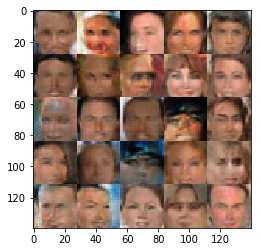

Epoch 1/1... Discriminator Loss: 1.5310... Generator Loss: 0.4503
Epoch 1/1... Discriminator Loss: 1.2657... Generator Loss: 0.8433
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.5532
Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 0.5980
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.5285
Epoch 1/1... Discriminator Loss: 1.2559... Generator Loss: 0.6644
Epoch 1/1... Discriminator Loss: 1.0774... Generator Loss: 0.9590
Epoch 1/1... Discriminator Loss: 1.2255... Generator Loss: 0.6676
Epoch 1/1... Discriminator Loss: 1.2924... Generator Loss: 0.8346
Epoch 1/1... Discriminator Loss: 1.2217... Generator Loss: 0.7100


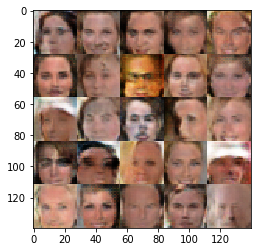

Epoch 1/1... Discriminator Loss: 1.0795... Generator Loss: 0.7698
Epoch 1/1... Discriminator Loss: 0.9907... Generator Loss: 0.9624
Epoch 1/1... Discriminator Loss: 1.0156... Generator Loss: 0.9518
Epoch 1/1... Discriminator Loss: 1.2374... Generator Loss: 0.8014
Epoch 1/1... Discriminator Loss: 1.2331... Generator Loss: 0.7601
Epoch 1/1... Discriminator Loss: 0.9821... Generator Loss: 1.0340
Epoch 1/1... Discriminator Loss: 0.9838... Generator Loss: 1.0440
Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 0.5982
Epoch 1/1... Discriminator Loss: 1.5116... Generator Loss: 0.4356
Epoch 1/1... Discriminator Loss: 1.1952... Generator Loss: 0.7327


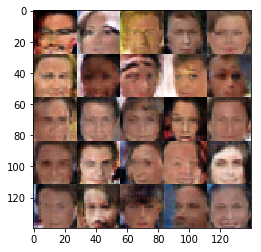

Epoch 1/1... Discriminator Loss: 0.9471... Generator Loss: 1.1588
Epoch 1/1... Discriminator Loss: 1.2148... Generator Loss: 0.8074
Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.5145
Epoch 1/1... Discriminator Loss: 1.2478... Generator Loss: 0.6495
Epoch 1/1... Discriminator Loss: 1.1030... Generator Loss: 0.8276
Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 0.7120
Epoch 1/1... Discriminator Loss: 1.2036... Generator Loss: 0.7233
Epoch 1/1... Discriminator Loss: 1.2104... Generator Loss: 0.9271
Epoch 1/1... Discriminator Loss: 1.1341... Generator Loss: 0.8754
Epoch 1/1... Discriminator Loss: 1.3048... Generator Loss: 0.6339


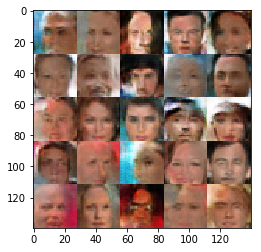

Epoch 1/1... Discriminator Loss: 1.0572... Generator Loss: 0.9768
Epoch 1/1... Discriminator Loss: 1.3219... Generator Loss: 0.6859
Epoch 1/1... Discriminator Loss: 1.0756... Generator Loss: 0.7522
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.5738
Epoch 1/1... Discriminator Loss: 1.6794... Generator Loss: 0.4137
Epoch 1/1... Discriminator Loss: 1.1864... Generator Loss: 0.7957
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.5604
Epoch 1/1... Discriminator Loss: 1.2286... Generator Loss: 0.6503
Epoch 1/1... Discriminator Loss: 1.3001... Generator Loss: 0.6715
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 0.6369


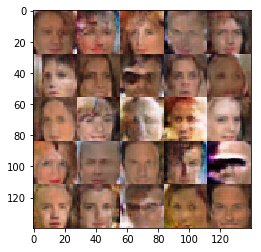

Epoch 1/1... Discriminator Loss: 1.1531... Generator Loss: 0.9292
Epoch 1/1... Discriminator Loss: 1.2993... Generator Loss: 1.6726
Epoch 1/1... Discriminator Loss: 1.4412... Generator Loss: 1.3137
Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 0.8757
Epoch 1/1... Discriminator Loss: 1.2775... Generator Loss: 0.7539
Epoch 1/1... Discriminator Loss: 1.4621... Generator Loss: 0.5229
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.6086
Epoch 1/1... Discriminator Loss: 1.5353... Generator Loss: 0.5161
Epoch 1/1... Discriminator Loss: 1.0824... Generator Loss: 1.0980
Epoch 1/1... Discriminator Loss: 1.1752... Generator Loss: 0.8078


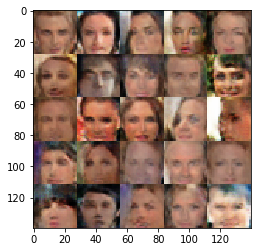

Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 1.4887... Generator Loss: 0.4560
Epoch 1/1... Discriminator Loss: 1.1726... Generator Loss: 0.8495
Epoch 1/1... Discriminator Loss: 1.3212... Generator Loss: 0.5638
Epoch 1/1... Discriminator Loss: 1.1658... Generator Loss: 0.9089
Epoch 1/1... Discriminator Loss: 1.4874... Generator Loss: 0.6685
Epoch 1/1... Discriminator Loss: 1.0861... Generator Loss: 0.9136
Epoch 1/1... Discriminator Loss: 1.1995... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.7060
Epoch 1/1... Discriminator Loss: 1.0949... Generator Loss: 0.9026


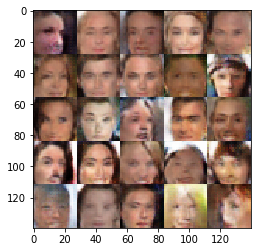

Epoch 1/1... Discriminator Loss: 1.3003... Generator Loss: 0.6484
Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 0.6327
Epoch 1/1... Discriminator Loss: 1.3148... Generator Loss: 0.6093
Epoch 1/1... Discriminator Loss: 1.6028... Generator Loss: 0.4897
Epoch 1/1... Discriminator Loss: 1.2668... Generator Loss: 0.8008
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.5828
Epoch 1/1... Discriminator Loss: 1.1256... Generator Loss: 0.8149
Epoch 1/1... Discriminator Loss: 1.0379... Generator Loss: 0.8917
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.2369... Generator Loss: 0.7705


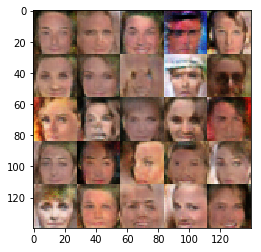

Epoch 1/1... Discriminator Loss: 1.5999... Generator Loss: 0.5354
Epoch 1/1... Discriminator Loss: 1.1180... Generator Loss: 1.1046
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.5532
Epoch 1/1... Discriminator Loss: 1.4604... Generator Loss: 0.4902
Epoch 1/1... Discriminator Loss: 1.1280... Generator Loss: 1.1414
Epoch 1/1... Discriminator Loss: 1.2483... Generator Loss: 0.7576
Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 0.5711
Epoch 1/1... Discriminator Loss: 1.2349... Generator Loss: 0.7113
Epoch 1/1... Discriminator Loss: 1.2108... Generator Loss: 0.6106
Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 0.8718


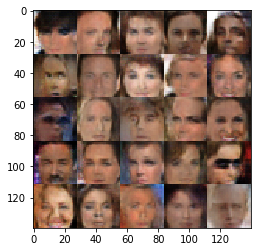

Epoch 1/1... Discriminator Loss: 1.1492... Generator Loss: 0.8585
Epoch 1/1... Discriminator Loss: 1.2569... Generator Loss: 0.6850
Epoch 1/1... Discriminator Loss: 1.1528... Generator Loss: 0.9849
Epoch 1/1... Discriminator Loss: 1.2442... Generator Loss: 0.6319
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.6316
Epoch 1/1... Discriminator Loss: 1.2654... Generator Loss: 0.7314
Epoch 1/1... Discriminator Loss: 1.1250... Generator Loss: 0.9240
Epoch 1/1... Discriminator Loss: 0.9413... Generator Loss: 1.2524
Epoch 1/1... Discriminator Loss: 1.6506... Generator Loss: 0.3713
Epoch 1/1... Discriminator Loss: 1.1798... Generator Loss: 0.7391


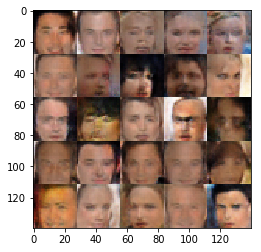

Epoch 1/1... Discriminator Loss: 1.1693... Generator Loss: 1.2017
Epoch 1/1... Discriminator Loss: 1.1661... Generator Loss: 1.0288
Epoch 1/1... Discriminator Loss: 1.0215... Generator Loss: 1.1033
Epoch 1/1... Discriminator Loss: 1.3404... Generator Loss: 0.6489
Epoch 1/1... Discriminator Loss: 1.1901... Generator Loss: 0.9518
Epoch 1/1... Discriminator Loss: 1.2329... Generator Loss: 0.6652
Epoch 1/1... Discriminator Loss: 1.3118... Generator Loss: 0.6897
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.7317
Epoch 1/1... Discriminator Loss: 1.0980... Generator Loss: 0.8817
Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.9274


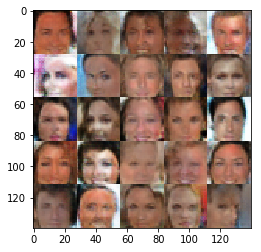

Epoch 1/1... Discriminator Loss: 1.2234... Generator Loss: 0.7070
Epoch 1/1... Discriminator Loss: 0.9062... Generator Loss: 1.2161
Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 0.5901
Epoch 1/1... Discriminator Loss: 1.1894... Generator Loss: 0.9588
Epoch 1/1... Discriminator Loss: 1.6134... Generator Loss: 0.4602
Epoch 1/1... Discriminator Loss: 1.2906... Generator Loss: 0.5659
Epoch 1/1... Discriminator Loss: 1.1985... Generator Loss: 0.8719
Epoch 1/1... Discriminator Loss: 1.2162... Generator Loss: 0.7708
Epoch 1/1... Discriminator Loss: 1.1631... Generator Loss: 0.8055
Epoch 1/1... Discriminator Loss: 1.1793... Generator Loss: 0.7069


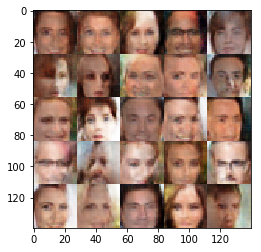

Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.5871
Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 0.6618
Epoch 1/1... Discriminator Loss: 1.5044... Generator Loss: 0.4944
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.4487
Epoch 1/1... Discriminator Loss: 1.1109... Generator Loss: 0.8094
Epoch 1/1... Discriminator Loss: 1.0926... Generator Loss: 0.8164
Epoch 1/1... Discriminator Loss: 1.1100... Generator Loss: 0.7613
Epoch 1/1... Discriminator Loss: 1.5670... Generator Loss: 0.4670
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.5700
Epoch 1/1... Discriminator Loss: 1.1798... Generator Loss: 0.7877


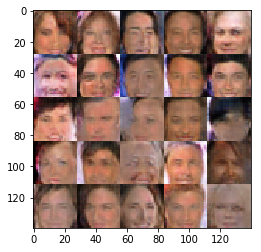

Epoch 1/1... Discriminator Loss: 1.4552... Generator Loss: 0.6137
Epoch 1/1... Discriminator Loss: 1.2385... Generator Loss: 0.7387
Epoch 1/1... Discriminator Loss: 1.1866... Generator Loss: 0.8988
Epoch 1/1... Discriminator Loss: 1.5675... Generator Loss: 0.5107
Epoch 1/1... Discriminator Loss: 1.5724... Generator Loss: 0.4905
Epoch 1/1... Discriminator Loss: 1.1588... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.1349... Generator Loss: 0.7408
Epoch 1/1... Discriminator Loss: 1.0593... Generator Loss: 0.8676
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.6150
Epoch 1/1... Discriminator Loss: 1.3400... Generator Loss: 0.6345


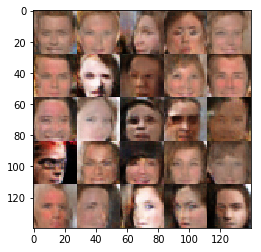

Epoch 1/1... Discriminator Loss: 1.1174... Generator Loss: 0.8092
Epoch 1/1... Discriminator Loss: 1.2282... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 1.2634... Generator Loss: 0.8243
Epoch 1/1... Discriminator Loss: 1.3414... Generator Loss: 0.7052
Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 0.7294
Epoch 1/1... Discriminator Loss: 1.2342... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 1.1948... Generator Loss: 0.7703
Epoch 1/1... Discriminator Loss: 1.1713... Generator Loss: 1.0065
Epoch 1/1... Discriminator Loss: 1.8777... Generator Loss: 0.3409
Epoch 1/1... Discriminator Loss: 1.1164... Generator Loss: 0.8102


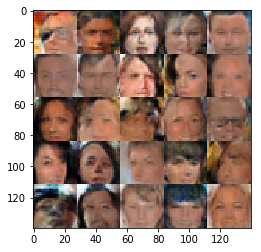

Epoch 1/1... Discriminator Loss: 1.2055... Generator Loss: 0.6903
Epoch 1/1... Discriminator Loss: 1.2059... Generator Loss: 0.7523
Epoch 1/1... Discriminator Loss: 1.5133... Generator Loss: 0.5163
Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.6847
Epoch 1/1... Discriminator Loss: 1.1483... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.1057... Generator Loss: 0.9534
Epoch 1/1... Discriminator Loss: 1.1722... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 1.1720... Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.5026
Epoch 1/1... Discriminator Loss: 1.3014... Generator Loss: 0.6342


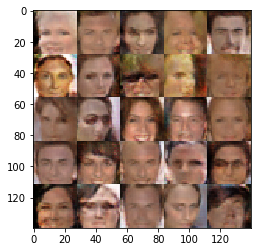

Epoch 1/1... Discriminator Loss: 1.2204... Generator Loss: 0.7220
Epoch 1/1... Discriminator Loss: 1.2316... Generator Loss: 0.6872
Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 0.6681
Epoch 1/1... Discriminator Loss: 1.5350... Generator Loss: 0.6074
Epoch 1/1... Discriminator Loss: 1.2475... Generator Loss: 0.6383
Epoch 1/1... Discriminator Loss: 1.2113... Generator Loss: 0.8470
Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 1.0022
Epoch 1/1... Discriminator Loss: 1.2427... Generator Loss: 1.0143
Epoch 1/1... Discriminator Loss: 1.1976... Generator Loss: 0.7906
Epoch 1/1... Discriminator Loss: 1.0978... Generator Loss: 0.8515


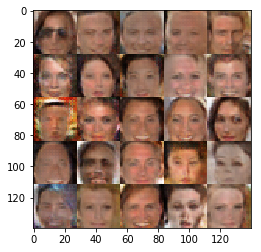

Epoch 1/1... Discriminator Loss: 1.2337... Generator Loss: 0.6772
Epoch 1/1... Discriminator Loss: 1.1601... Generator Loss: 0.8361
Epoch 1/1... Discriminator Loss: 1.1096... Generator Loss: 0.8413
Epoch 1/1... Discriminator Loss: 1.1725... Generator Loss: 0.7218
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.5867
Epoch 1/1... Discriminator Loss: 1.2630... Generator Loss: 0.9026
Epoch 1/1... Discriminator Loss: 1.1935... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 1.1808... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.3290... Generator Loss: 0.5590
Epoch 1/1... Discriminator Loss: 1.3101... Generator Loss: 0.7065


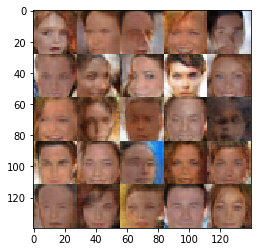

Epoch 1/1... Discriminator Loss: 1.3400... Generator Loss: 0.5544
Epoch 1/1... Discriminator Loss: 1.1951... Generator Loss: 1.0089
Epoch 1/1... Discriminator Loss: 1.2195... Generator Loss: 0.7063
Epoch 1/1... Discriminator Loss: 1.2776... Generator Loss: 1.2015
Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 0.5329
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.4910
Epoch 1/1... Discriminator Loss: 1.0416... Generator Loss: 1.0290
Epoch 1/1... Discriminator Loss: 1.6284... Generator Loss: 0.4039
Epoch 1/1... Discriminator Loss: 1.3271... Generator Loss: 0.8032
Epoch 1/1... Discriminator Loss: 1.5435... Generator Loss: 0.4593


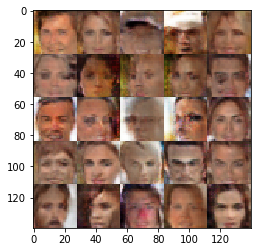

Epoch 1/1... Discriminator Loss: 1.1026... Generator Loss: 1.0232
Epoch 1/1... Discriminator Loss: 1.2283... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 1.4338... Generator Loss: 0.5967
Epoch 1/1... Discriminator Loss: 0.8437... Generator Loss: 1.2614
Epoch 1/1... Discriminator Loss: 1.8177... Generator Loss: 0.3264
Epoch 1/1... Discriminator Loss: 1.1928... Generator Loss: 0.7839
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.5232
Epoch 1/1... Discriminator Loss: 1.0792... Generator Loss: 0.9292
Epoch 1/1... Discriminator Loss: 1.1912... Generator Loss: 1.0138
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.5876


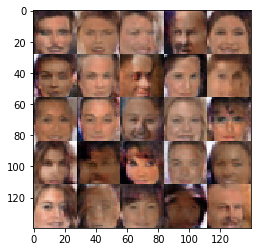

Epoch 1/1... Discriminator Loss: 1.1086... Generator Loss: 0.9283
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.7256
Epoch 1/1... Discriminator Loss: 1.1337... Generator Loss: 0.8811


In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.